/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/2435292544.py:352: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/2435292544.py:352: RuntimeWarning: divide by zero encountered in divide
  t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/2435292544.py:352: RuntimeWarning: invalid value encountered in multiply
  t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)


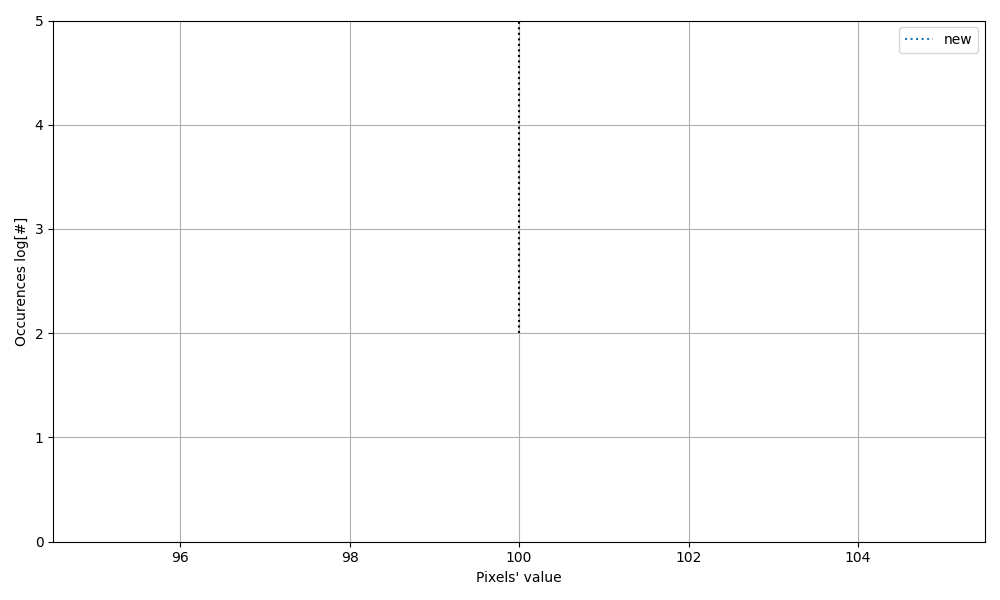

/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/2435292544.py:352: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/2435292544.py:352: RuntimeWarning: divide by zero encountered in divide
  t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/2435292544.py:352: RuntimeWarning: invalid value encountered in multiply
  t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/2435292544.py:352: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
/var/folders/m8/f6l41h_51qx

In [457]:
%matplotlib ipympl

import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import numpy as np
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.special as sps
import numpy as np
# from scipy.stats import poisson
from scipy.stats import poisson,gamma


n_pix = 10 ** 5
def simulate_emccd_image(
    ConversionGain,
    EmGain,
    Bias,
    RN,
    Smearing,
    SmearExpDecrement,
    flux,
    sCIC=0,
    n_registers=604,
):
    """Silumate EMCCD histogram
    flux = flux + dark + CIC 
    im = ConversionGain * gamma( poisson(np.nanmax([flux, 0]), abs(EmGain) )
    gamma( poisson(1 * id_scic), np.power(EmGain, np.random.randint(1, n_registers, size=id_scic.shape)  / n_registers)
    smearing(im) + normal(Bias, abs(RN * ConversionGain))

    """
    import numpy as np
    from scipy.sparse import dia_matrix

    # recover number of pixels to generate distributions

    n = 1
    # im = np.zeros(int(n_pix))  #
    im = np.zeros((1000, int(n_pix / 1000)))
    # print(flux)
    imaADU = np.random.gamma(np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain))
    # changing total sCIC (e-) into the percentage of pixels experiencing spurious electrons
    # TODO maybe should be changed
    p_sCIC = (1-np.exp(-sCIC))#sCIC 
    # p_sCIC = (1-np.exp(-sCIC))#sCIC 
    # pixels in which sCIC electron might appear
    id_scic = np.random.rand(im.shape[0], im.shape[1]) < p_sCIC
    # stage of the EM register at which each sCIC e- appear
    register = np.random.randint(1, n_registers, size=id_scic.shape)
    # Compute and add the partial amplification for each sCIC pixel
    # when f=1e- gamma is equivalent to expoential law
    # should we add poisson here?
    imaADU += np.random.gamma(np.random.poisson(1 * id_scic), np.power(EmGain, register / n_registers))
    # imaADU += np.random.gamma(1 * id_scic, np.power(EmGain, register / n_registers))
    # imaADU[id_scic] += np.random.gamma(1, np.power(EmGain, register / n_registers))
    imaADU *= ConversionGain
    # smearing data
    def variable_smearing_kernels(
        image, Smearing=0.7, SmearExpDecrement=50000/2, type_="exp"
    ):
        """Creates variable smearing kernels for convolution or inversion
        """
        import numpy as np
        n = 30
        smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
        if type_ == "exp":
            smearing_kernels = np.exp(
                -np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length
            )
        else:
            assert 0 <= Smearing <= 1
            smearing_kernels = np.power(Smearing, np.arange(n))[
                :, np.newaxis, np.newaxis
            ] / np.ones(smearing_length.shape)
        smearing_kernels /= smearing_kernels.sum(axis=0)
        return smearing_kernels

    if Smearing > 0:
        n=30
        # smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / Smearing)
        # smearing_kernels /= smearing_kernels.sum(axis=0)
        smearing_kernels = variable_smearing_kernels(
            imaADU, Smearing, SmearExpDecrement
        )
        n_smearing = smearing_kernels.shape[0]
        offsets = np.arange(n_smearing)
        A = dia_matrix(
            (smearing_kernels.reshape((n_smearing, -1)), offsets),
            shape=(imaADU.size, imaADU.size),
        )
        imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
    # adding read noise and bias
    read_noise = np.random.normal(0, abs(RN * ConversionGain), size=im.shape)
    imaADU += Bias
    imaADU += read_noise
    return imaADU




def EMCCDhist(
    x,
    bias=[1e3, 4.5e3, 1194],
    RN=[0, 350, 53],
    EmGain=[100, 10000, 5000],
    flux=[0.0001, 1, 0.04],
    smearing=[0, 1.8, 0.01],
    sCIC=[0, 1, 0],
):
    """
    Stochastic model for EMCCD histogram.
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    # def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
    from scipy.sparse import dia_matrix
    import inspect
    from astropy.table import Table
    # from matplotlib.widgets import Button
    import numpy as np

    # if bias > 1500:
    #     ConversionGain = 0.53  # 1/4.5 #ADU/e-  0.53 in 2018
    # else:
    #     ConversionGain = 1 / 4.5  # ADU/e-  0.53 in 2018
    ConversionGain = 1  # /4.5


    # print("flux=",flux,"Smearing=", smearing)
    imaADU = simulate_emccd_image(
        ConversionGain=ConversionGain, 
        EmGain=EmGain,
        Bias=bias,
        RN=RN,
        Smearing=smearing,
        SmearExpDecrement=1e10,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
        n_registers=604,
        flux=flux,
        sCIC=sCIC,
    )

    range = [np.nanmin(x), np.nanmax(x)]
    y, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))


    y[y == 0] = 1.0
    # y = y / (x[1] - x[0])
    # y = y / (bins[1] - bins[0])
    # print(np.nansum(y))
    return np.log10(y)




    

def EMCCD_with_smearing(x,bias,RN,EmGain,flux,smearing,sCIC,):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    try:
        _, y, _ = np.loadtxt("/tmp/xy.txt").T
        # x, y =  np.array(x), np.array(y)
    except (OSError, ValueError) as e:
        try:
            _, y = np.loadtxt("/tmp/xy.txt").T

        except (OSError, ValueError) as e:
            _, y = np.array([0, 1]), np.array([0, 1])

    # recover number of pixels to generate distributions

    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))

    energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
    gamma_distribution = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*energy_fraction_kept, flux=flux,sCIC=sCIC)

    if smearing>0. :
        for i in range(1,4):
            smeared_distri = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*np.exp(-i/smearing), flux=(1+np.exp(-i/smearing))*flux,sCIC=0)   * np.exp(-i*flux) #/smearing
            gamma_distribution[1:] +=  smeared_distri[1:]
            gamma_distribution[0] -= np.sum(smeared_distri[1:])


    # Addition of the bias
    if bias > x[0]:
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    read_noise = Gaussian1DKernel(
        stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
    )
    # Convolution with read noise
    y = convolve(gamma_distribution, read_noise) * n_pix  #
    # y /= x[1] - x[0]
    y[y<1]=1
    return np.log10(y)





def EMCCD_with_smearing2(
    x,
    bias,#=[x.min(), x.max(), x[np.argmax(y)]],
    RN,#=[5, 350, 12],
    EmGain,#=[10, 2000, 1900],
    flux,#=[0, 1, 0.01],
    smearing,#=[0, 3, 0.01],
    sCIC,#C=[0, 2, 0],
    test=True
):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))

    energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
   
    gamma_distribution =  EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*energy_fraction_kept, flux=flux,sCIC=sCIC)

    if (smearing>0.0)  :
        for i in range(1,4):
            smeared_distri = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*np.exp(-i/smearing), flux=flux,sCIC=0)   * np.exp(-i*flux) #/smearing
            gamma_distribution[1:] +=  smeared_distri[1:]
            gamma_distribution[0] -= np.sum(smeared_distri[1:])



    # Addition of the bias
    if bias > x[0]:
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    read_noise = Gaussian1DKernel(
        stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
    )
    # Convolution with read noise
    y = convolve(gamma_distribution, read_noise) * n_pix  #
    y[y<=0] = np.nan
    return np.log10(y)



def EMCCD_no_smearing(x,bias,RN,EmGain,flux,sCIC):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))
    bins = x - np.nanmin(x)
    distributions = []
    pixs_sup_0 = 0  # fraction of pixels that have ADU higher than distribution limit
    # for smearing we consider each pixel recieve x% of their flux and Then
    # they receive the rest with a lower gain. This approximation is # NOTE:
    # true and need to be revised. The interest is that it is then independant
    # draws and that distributions can be convoluted.
    # for i, (flux_, EmGain) in enumerate(zip(fluxes, emgains)):
    gamma_distribution = 0
    # We sum up distributions from from the different poisson output
    for f in np.arange(1, 20):  
        # careful about the 20 limit which needs to be enough at high flux
        v = poisson.pmf(k=f, mu=np.nanmax([flux, 0])) #TODO maybe here I miss a binomial law?? At least gamma distribution seems ok!
        # gamma distribution : https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html
        denominator = sps.gamma(f) * (EmGain * ConversionGain) ** f
        # print("denominator",denominator)
        distribution = (bin_size* bins ** (f - 1)* (np.exp(-bins / (EmGain * ConversionGain)) / denominator))
        # print("distribution",distribution)
        n=3
        distribution_up = (n* bin_size* (n * bins + bins.ptp()) ** (f - 1)* (    np.exp(-(n * bins + bins.ptp()) / (EmGain * ConversionGain))    / denominator))
        # disminush the number of pixels by the fraction above distribution range
        if  (np.sum(distribution_up[np.isfinite(distribution_up)])  + np.sum(distribution[np.isfinite(distribution)])  )>0:
            factor = np.sum(distribution[np.isfinite(distribution_up)]) / (np.sum(distribution_up[np.isfinite(distribution_up)])  + np.sum(distribution[np.isfinite(distribution)])  )
        else:
            factor=0
        gamma_distribution += distribution * v
        pixs_sup_0 += (1 - factor) * v
    gamma_distribution[0] = np.exp(-flux)
    # gamma_distribution[0] = (
    #     1
    #     - np.nansum(gamma_distribution[1:][np.isfinite(gamma_distribution[1:])])
    #     - pixs_sup_0
    # )

    # adding sCIC and comvolving distributions as independant draws.
    # if sCIC > 0:
    #     # changing total sCIC (e-) into the percentage of pixels experiencing spurious electrons
    #     p_sCIC = sCIC  # / np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))
    #     # Estimation of average gain for semi-amplified CIC
    #     gain_ = np.power(EmGain * ConversionGain, np.linspace(1, n_registers, 100) / n_registers)
    #     cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
    #     cic_disdribution /= cic_disdribution.sum()
    #     cic_disdribution *= p_sCIC
    #     cic_disdribution[0] = 1 - np.sum(cic_disdribution[1:])
    #     cic_disdribution = np.hstack((np.zeros(len(cic_disdribution) - 1), cic_disdribution))
    #     gamma_distribution = np.convolve(gamma_distribution, cic_disdribution, mode="valid")
    # distributions.append(gamma_distribution)

    if sCIC>0:
        gain_ = np.power(EmGain *np.sqrt(2)  , np.linspace(1, n_registers, 100) / n_registers)
        cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
        cic_disdribution *= 1.3*np.exp(-flux)*(1-np.exp(-sCIC)) / cic_disdribution.sum()
        gamma_distribution[1:]  += cic_disdribution[1:]
        gamma_distribution[0] -= np.sum(cic_disdribution[1:]) 


    # Addition of the bias
    if (bias > x[0]) & (bias!=0):
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    read_noise = Gaussian1DKernel(
        stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
    )
    # Convolution with read noise
    if RN>0:
        y = convolve(gamma_distribution, read_noise) * n_pix  #
    else:
        y = gamma_distribution
    # y /= x[1] - x[0]
    # y[y<=0] =np.nan
    return y




def EMCCD_no_smearing2(x,bias,RN,EmGain,flux,smearing,sCIC):
    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    # bin_size = np.median((x[1:] - x[:-1]))
    bins = x# - np.nanmin(x)
    gamma = np.power(EmGain,1/n_registers)
    t1 = 1/(np.sqrt(2*np.pi)*RN) * np.exp(-flux - (bins-bias)**2/(2*RN**2)) * np.exp(-sCIC/n_registers)
    t2 = 2/EmGain * ncx2.pdf(2*(flux),4,2*(bins-bias)/EmGain)
    # t3 = sCIC/m/2 * np.sum([1/gamma**i *np.exp(-(n-bias)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) * np.exp(-flux-sCIC)
    gamma_distribution = t1+t2
    if sCIC>0:
        gain_ = np.power(EmGain *np.sqrt(2)  , np.linspace(0, n_registers, 100) / n_registers)
        cic_disdribution = 2* np.exp(-flux) * np.sum([2/gaini * ncx2.pdf(2*(sCIC/n_registers),4,2*(bins-bias)/gaini) for gaini in gain_], axis=0) 
        cic_disdribution[bins<=bias+2*RN] =0
        gamma_distribution += cic_disdribution
        gamma_distribution[0] -= np.sum(cic_disdribution[1:])  
    gamma_distribution[bins<=bias] = t1[bins<=bias]
    diff =  gamma_distribution[bins-bias<=0][-1] + gamma_distribution[bins-bias>0][0]
    # gamma_distribution[bins-bias>0] = gamma_distribution[bins-bias>0]  - diff
    gamma_distribution[bins==bias+1] = (gamma_distribution[bins==bias]+gamma_distribution[bins==bias+2])/2
    return 6.2+np.log10(gamma_distribution)



x = np.linspace(-200,5000,350)
bias=100
fig, ax = plt.subplots(figsize=(10,6))
def EMCCD_dev_wo(x,bias,RN,EmGain,flux,smearing,sCIC,test=False):
    return EMCCD_dev(x,bias,RN,EmGain,flux,smearing,sCIC,test=test)
ylim=[0.,5]
controls = iplt.plot(x, EMCCD_no_smearing2 , bias=np.linspace(0,1000), RN=np.linspace(30,100),EmGain=np.linspace(1000,2000),flux=np.linspace(0.,2), smearing=np.linspace(0,1.2),sCIC=np.linspace(0,2),ls=":", ylim=ylim, label="new")#,fmt="."
iplt.plot(x, EMCCDhist,controls=controls, ylim=ylim,label="Draws")
# iplt.plot(x, EMCCD_with_smearing,controls=controls, ylim=ylim,label="Analytical")
# iplt.plot(x, EMCCD_with_smearing2, "-", controls=controls, ylim=ylim, label="EMCCD dev")#,alpha=0.3)
_ = plt.legend()
plt.plot([bias,bias],[2,5],":k")
plt.legend()
plt.grid()
plt.xlabel("Pixels' value")
plt.ylabel("Occurences log[#]")
fig.tight_layout()
plt.show()



In [ ]:
x^n = 

0.05000748405006382 0.048770575499285984


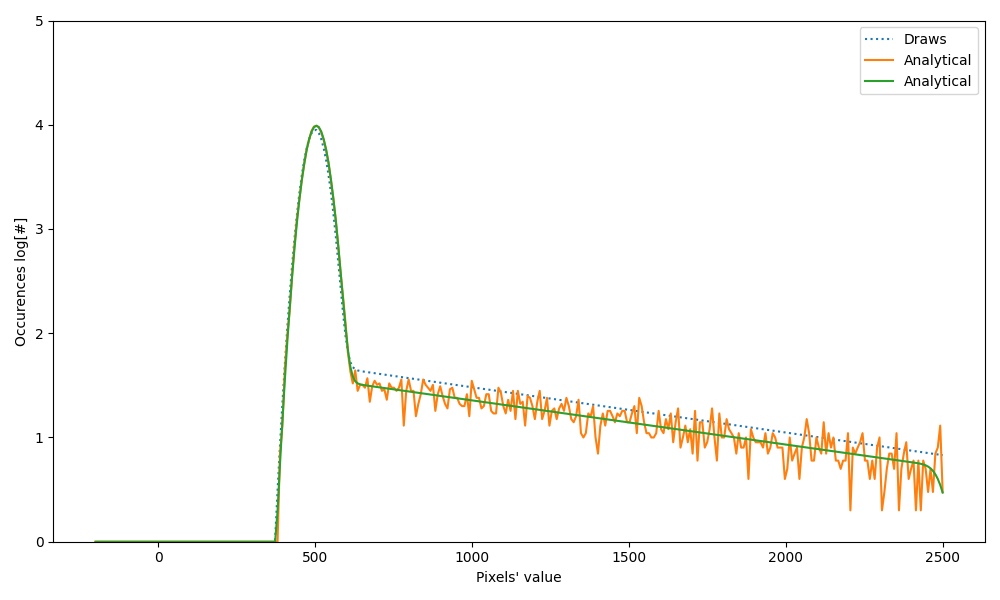

0.2422339308468915 0.22357965557092851
0.4186358572466779 0.36626376800762483
0.8478386085476195 0.6553776580171727
0.8870781623822787 0.7704027452859552
0.8929439603563343 0.8470357462347791
0.8955476567010724 0.8980908419001247
0.8973741247989782 0.9321052059616122
0.8980971005112598 0.9445823499416082
0.8987819653646979 0.9630791775051415
0.8990496344835098 0.969864181048532
0.8995018890142307 0.9799226560297669
0.8998693328873785 0.9866238995678788
0.900430145918823 0.9940628770348556
0.9007468284038007 0.9967714245807667
0.9011479471874856 0.9988303145449602
0.90139147685032 0.9994808227994135


In [299]:

# pp= 0.1#pCIC
# n= np.linspace(-100,1000,1000)#ADU
# n0=200#bias
# sigma=20#RN
# gamma=1.01
# m=604
# ps= 0.1/m##sCIC

# p1 = (1-pp-m*ps)*np.exp(-(n-n0)**2/(2*sigma**2))/(2*sigma*np.sqrt(np.pi))
# p2 = pp * 1/gamma**m *np.exp(-(n-n0)/gamma**m)
# p3 = ps * np.sum([1/gamma**i *np.exp(-(n-n0)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) 
# p2[n<=n0]=0
# p3[n<=n0]=0
# plt.semilogy(n,p1)
# plt.semilogy(n,p2)

# plt.semilogy(n,p3,".")
# plt.semilogy(n,p1+p2)
# plt.semilogy(n,p1+p2+p3)
# plt.ylim(ymin=0.00001,ymax=100)

def harpsoe(x, bias,RN,EmGain,flux,smearing,sCIC):
    m=604
    gamma = np.power(EmGain,1/m)
    p1 = (1-flux-sCIC/2)*np.exp(-(x-bias)**2/(2*RN**2))/(2*RN*np.sqrt(np.pi))
    p2 = flux * 1/gamma**m *np.exp(-(x-bias)/EmGain)
    p3 = sCIC/m/2 * np.sum([1/gamma**i *np.exp(-(x-bias)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) 
    p2[x<=bias+1]=0
    p3[x<=bias+1]=0
    p = p1+p2+p3
    p[p<=0] = np.nan
    # print(p)
    print(np.nansum(p[x>bias+5.5*RN]) / np.nansum(p), 1-np.exp(-flux) )
    return np.log10(p)+6



x = np.linspace(-200,2500,350)
bias=100
fig, ax = plt.subplots(figsize=(10,6))
def EMCCD_dev_wo(x,bias,RN,EmGain,flux,smearing,sCIC,test=False):
    return EMCCD_dev(x,bias,RN,EmGain,flux,smearing,sCIC,test=test)
ylim=[0,5]
# ylim=[None,None]
controls = iplt.plot(x,  harpsoe, bias=500, RN=np.linspace(30,100),EmGain=np.linspace(1000,2000),flux=np.linspace(0.05,10), smearing=np.linspace(0,1.2),sCIC=np.linspace(0,0.3),ls=":", ylim=ylim, label="Draws")
iplt.plot(x, EMCCDhist,controls=controls, ylim=ylim,label="Analytical")
iplt.plot(x, EMCCD_with_smearing,controls=controls, ylim=ylim,label="Analytical")
# iplt.plot(x, EMCCD_with_smearing2, "-", controls=controls, ylim=ylim, label="EMCCD dev")#,alpha=0.3)
_ = plt.legend()
# plt.plot([bias,bias],[2,5],":k")
plt.legend()
plt.xlabel("Pixels' value")
plt.ylabel("Occurences log[#]")
fig.tight_layout()
plt.show()



In [333]:
np.linspace(0,1000,1001)

array([   0.,    1.,    2., ...,  998.,  999., 1000.])

[] [0.01269001] []


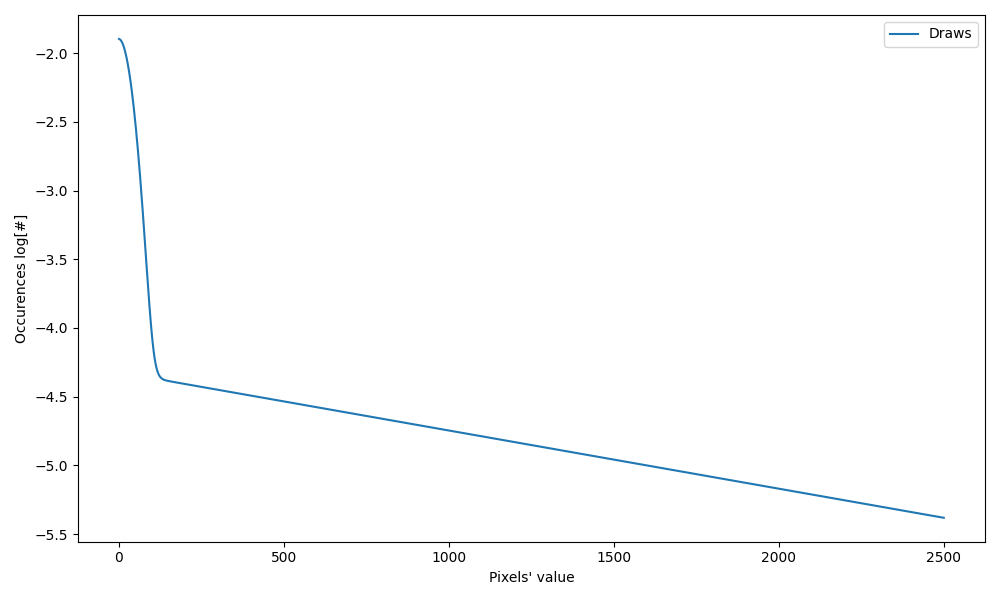

[0.01264952] [0.01269001] [4.04895613e-05]
[0.01264952] [0.01269001] [4.04895613e-05]
[0.01264952] [0.01269001] [4.04895613e-05]
[0.01264952] [0.01295948] [0.00030996]
[0.01264952] [0.01348858] [0.00083906]
[0.01264952] [0.01571295] [0.00306343]
[0.01264952] [0.01748729] [0.00483776]
[0.01264952] [0.01850571] [0.00585619]
[0.00932331] [0.01382303] [0.00449973]
[0.00687173] [0.01032348] [0.00345175]
[0.00059846] [0.00099342] [0.00039496]
[3.84145336e-05] [7.05982149e-05] [3.21836812e-05]
[6.15844076e-06] [1.20497398e-05] [5.89129901e-06]


In [336]:
from scipy.special import gamma, hyp1f1
import numpy as np
from scipy.stats import ncx2

n = np.linspace(1,2500,2500)
bias=100

def hirsch(n, g, rn, Lambda,bias,sCIC):
    m=604
    gamma = np.power(g,1/m)
    t1 = 1/(np.sqrt(2*np.pi)*rn) * np.exp(-Lambda - (n-bias)**2/(2*rn**2))
    t2 = 2/g * ncx2.pdf(2*(Lambda+sCIC),4,2*(n-bias)/g)
    t3 = sCIC/m/2 * np.sum([1/gamma**i *np.exp(-(n-bias)/gamma**i) for i in np.linspace(1,m,m+1)],axis=0) * np.exp(-Lambda-sCIC)
    # t2[n<=0]=1
    t_tot = t1+t2 + t3
    t_tot[n-bias<=0] = t1[n-bias<=0]
    # index = n.index
    print(t_tot[n==bias],t_tot[n==bias+1],t_tot[n==bias+1]-t_tot[n==bias])
    return np.log10(t_tot)
    # if n>0:
    #     return t1+t2
    # else:
    #     return t1
ylim=None#[0,5]

# ylim=[-10,-2]
fig, ax = plt.subplots(figsize=(10,6))
controls = iplt.plot(n,  hirsch,  g=np.linspace(1000,2000), rn=np.linspace(30,100),Lambda=np.linspace(0.05,15),bias=np.linspace(0,1000,1001),sCIC=np.linspace(0,0.3),ls=None, ylim=ylim, label="Draws")
_ = plt.legend()
plt.legend()
plt.xlabel("Pixels' value")
plt.ylabel("Occurences log[#]")
fig.tight_layout()
plt.show()



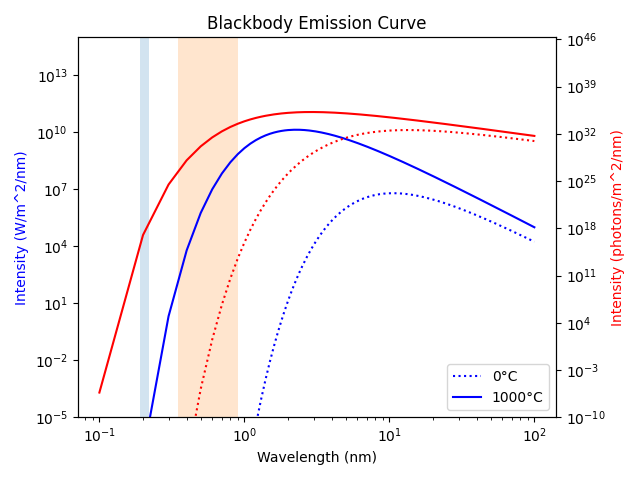

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h = 6.626e-34  # Planck's constant in m^2 kg / s
c = 3.0e8  # Speed of light in m/s
k = 1.38e-23  # Boltzmann constant in m^2 kg / s^2 / K
# T = 20000 + 273.15  # Temperature in Kelvin (20 degrees Celsius)

# Wavelength range in micrometer
wavelengths = np.linspace(1e-1, 100, 1000) 
# Blackbody emission formula
def blackbody(wavelength, T):
    a = 2.0 * h * c**2
    b = h * c / (wavelength * k * (T+ 273.15))
    intensity = a / (wavelength**5 * (np.exp(b) - 1.0))
    return intensity


# Plotting
fig, ax1 = plt.subplots()

# Left y-axis: normal units (W/m^2/nm)
ax1.loglog(wavelengths * 1,  blackbody(wavelengths* 1e-6, 0), 'b:',label="0°C")
ax1.loglog(wavelengths * 1,  blackbody(wavelengths* 1e-6, 1000), 'b-',label="1000°C")
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Intensity (W/m^2/nm)', color='b')

ax1.fill_between(x=[190*1e-3,220*1e-3],y1=[1e18,1e18],alpha=0.2)
ax1.fill_between(x=[350*1e-3,900*1e-3],y1=[1e18,1e18],alpha=0.2)
ax1.set_ylim(ymin=1e-5,ymax=1e15)
ax2 = ax1.twinx()#functions=(lambda x: T_c*1.8 + 32.,  lambda x: (T_f - 32.)/1.8))

ax2.loglog(wavelengths * 1, blackbody(wavelengths* 1e-6, 0) / (h * c / wavelengths), 'r:')
ax2.loglog(wavelengths * 1, blackbody(wavelengths* 1e-6, 1000) / (h * c / wavelengths), 'r-')
ax2.set_ylabel('Intensity (photons/m^2/nm)', color='r')
plt.title('Blackbody Emission Curve')
ax1.legend(loc="lower right")
ax2.set_ylim(ymin=1e-10)
fig.tight_layout()
plt.show()


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/4229467633.py:12: RuntimeWarning: overflow encountered in exp
  second_term = 1 / (np.exp((const.h * const.c) / (wavelength_m * const.k * temperature)) - 1)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/4229467633.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated_flux, _ = quad(lambda w: radiance_to_photon_flux(planck_law(w * 1e-3, temperature+273.15), w * 1e-3) *


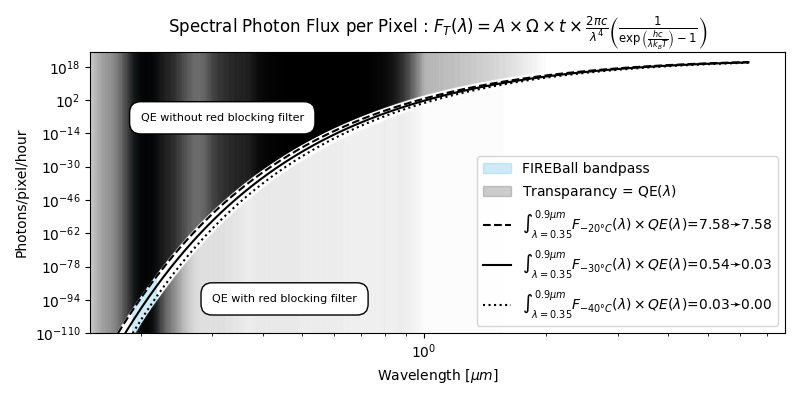

In [281]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.integrate import quad
QE = Table.read("/Users/Vincent/Github/FIREBallIMO/FireBallIMO/PSFDetector/efficiencies/QE_2024.txt",format="ascii")[1:-1]

def planck_law(wavelength, temperature):
    # Convert wavelength to meters for the formula
    wavelength_m = wavelength * 1e-6
    # Calculate spectral radiance using Planck's Law
    first_term = (2.0 * const.h * const.c**2) / wavelength_m**5
    second_term = 1 / (np.exp((const.h * const.c) / (wavelength_m * const.k * temperature)) - 1)
    return first_term * second_term

def radiance_to_photon_flux(radiance, wavelength):
    # Convert radiance (energy) to photon flux (number of photons)
    energy_per_photon = const.h * const.c / (wavelength * 1e-6)
    return radiance / energy_per_photon

# Constants and parameters
# temperature = -30+273.15  # Temperature in Kelvins (0 degrees Celsius)
# time = 3600  # Time in seconds (1 hour)
# pixel_area = (13e-6)**2  # 13-micron pixel in meters squared
  # Steradian
wavelength_band = (190e-9, 220e-9)  # Wavelength range for QE is 200-210 nm

# Create wavelength array in microns for plotting
wavelengths = np.logspace(-1,0.8, 600)  # Wavelengths from 0.1 to 1 micron

def photon_flux(wavelengths,temperature,solid_angle = 2 * np.pi, pixel_area = (13e-6)**2,time = 3600):
    photon_fluxes = []
    for wl in wavelengths:
        radiance = planck_law(wl, temperature+273.15)
        photon_flux = radiance_to_photon_flux(radiance, wl)
        photon_fluxes.append(photon_flux * solid_angle * time * pixel_area)
    return photon_fluxes

# Calculate the spectral radiance for each wavelength and convert to photon flux

# Convert the range from nanometers to microns for integration and fill_between
wavelength_range_microns = (wavelength_band[0]*1e3, wavelength_band[1]*1e3)

# Integrate photon flux over the desired wavelength band
integrated_flux, _ = quad(lambda w: radiance_to_photon_flux(planck_law(w * 1e-3, temperature), w * 1e-3) *
                           solid_angle * time * pixel_area * quantum_efficiency,
                           wavelength_range_microns[0], wavelength_range_microns[1])
integrated_flux2, _ = quad(lambda w: radiance_to_photon_flux(planck_law(w * 1e-3, temperature), w * 1e-3) *
                           solid_angle * time * pixel_area * quantum_efficiency,
                           350, 900)
def integrated_flux(wmin,wmax,temperature,quantum_efficiency,solid_angle = 2 * np.pi, pixel_area = (13e-6)**2,time = 3600):
    integrated_flux, _ = quad(lambda w: radiance_to_photon_flux(planck_law(w * 1e-3, temperature+273.15), w * 1e-3) *
                           solid_angle * time * pixel_area * quantum_efficiency(w)/100,
                           wmin, wmax)
    return integrated_flux

from scipy.interpolate import interp1d
QE_interp0 = interp1d(QE["wave"],QE["FIREBall 3-layer ARC Model"])
QE_interp1 = interp1d(QE["wave"],QE["eff. QE (1layer)"])
QE_interp2 = interp1d(QE["wave"],QE["eff. QE (2 layers)"])

fig, ax = plt.subplots(figsize=(8,4))        

ax.fill_between(wavelengths, 1e-200, 1e25, where=(wavelengths >= wavelength_band[0]*1e6) & (wavelengths <=  wavelength_band[1]*1e6), color='skyblue', alpha=0.4,label="FIREBall bandpass")
ax.fill_between(wavelengths, 1e-200, 1e-200, where=(wavelengths >= wavelength_band[0]*1e6) & (wavelengths <=  wavelength_band[1]*1e6), color='grey', alpha=0.4,label=r"Transparancy = QE$(\lambda$)")

# ax.fill_between(wavelengths, 1e-200, photon_flux(wavelengths,-30), where=(wavelengths >= wavelength_band[0]*1e6) & (wavelengths <=  wavelength_band[1]*1e6), color='skyblue', alpha=0.4)#,label="Integrated flux ~ %0.1E"%(integrated_flux))
# ax.fill_between(wavelengths, 1e-200, photon_flux(wavelengths,-30), where=(wavelengths >= 0.350) & (wavelengths <=  0.900), color='orange', alpha=0.4)#,label="Integrated flux ~ %0.1E"%(integrated_flux2))

for i in range(len(wavelengths)):
    try:
        ax.fill_between([wavelengths[i], wavelengths[i+1]], 1e-200, 0.01*np.array([photon_flux(wavelengths,-40)[i], photon_flux(wavelengths,-40)[i+1]]),color="k",alpha=float(QE_interp1(1e3*wavelengths[i])/100))
        ax.fill_between([wavelengths[i], wavelengths[i+1]], 100*np.array([photon_flux(wavelengths,-20)[i], photon_flux(wavelengths,-20)[i+1]]),[1e30,1e30],color="k",alpha=float(QE_interp0(1e3*wavelengths[i])/100))
    except (ValueError, IndexError) as e:
        # print("i =" , wavelengths[i])
        pass
ax.loglog(wavelengths, photon_flux(wavelengths,-20), "k--",label=r'$\int_{\lambda=0.35}^{0.9\mu m}F_{-20°C}(\lambda)\times QE(\lambda)$=%0.2f➛%0.2f'%(integrated_flux(350,900,-20,QE_interp0),integrated_flux(350,900,-20,QE_interp0)))
ax.loglog(wavelengths, photon_flux(wavelengths,-30),"k-", label= r'$\int_{\lambda=0.35}^{0.9\mu m}F_{-30°C}(\lambda)\times QE(\lambda)$=%0.2f➛%0.2f'%(integrated_flux(350,900,-30,QE_interp0),integrated_flux(350,900,-30,QE_interp1)))
ax.loglog(wavelengths, photon_flux(wavelengths,-40), "k:",label= r'$\int_{\lambda=0.35}^{0.9\mu m}F_{-40°C}(\lambda)\times QE(\lambda)$=%0.2f➛%0.2f'%(integrated_flux(350,900,-40,QE_interp0),integrated_flux(350,900,-40,QE_interp1)))


plt.text(0.2,1e-8,'QE without red blocking filter',bbox=dict(facecolor='white',edgecolor='black',boxstyle='round,pad=1'),fontsize=8)
plt.text(0.3,1e-95,'QE with red blocking filter',bbox=dict(facecolor='white',edgecolor='black',boxstyle='round,pad=1'),fontsize=8)


ax.set_xlabel(r"Wavelength [$\mu m$]")
ax.set_ylabel('Photons/pixel/hour')
# ax.set_title('Spectral Photon Flux per Pixel : ' + r"$F_T(\lambda) = A \times \Omega \times t \times \int_{\lambda_1}^{\lambda_2} \frac{2 \pi c}{\lambda^4} \left( \frac{1}{\exp\left(\frac{hc}{\lambda k_B T}\right) - 1} \right) \times QE(\lambda) , d\lambda $")
ax.set_title('Spectral Photon Flux per Pixel : ' + r"$F_T(\lambda) = A \times \Omega \times t \times  \frac{2 \pi c}{\lambda^4} \left( \frac{1}{\exp\left(\frac{hc}{\lambda k_B T}\right) - 1} \right) $")
ax.legend()#title=f"Integrated Flux: {integrated_flux:.2e} photons/pixel/hour\nin 200-210nm band")
ax.set_ylim(ymin=1e-110,ymax=1e25)
ax.set_xlim(xmin=0.15)
# Show plot
fig.tight_layout()
plt.show()

In [264]:
QE

wave,FIREBall 1-layer ARC Model,FIREBall 3-layer ARC Model,FIREBall 5-layer ARC Model,eff. QE (1layer),eff. QE (2 layers)
int64,float64,float64,float64,float64,float64
100,10.7048,1.8236,0.4298,0.0349,0.0004
101,10.7985,1.8757,0.4501,0.036,0.0005
102,10.8936,1.9278,0.4708,0.0371,0.0007
103,10.9901,1.9799,0.4916,0.0383,0.0009
104,11.088,2.032,0.5125,0.0397,0.0012
105,11.1873,2.084,0.5333,0.0413,0.0016
106,11.2879,2.1361,0.5541,0.0431,0.0021
107,11.3898,2.1884,0.5748,0.0451,0.0028
108,11.4931,2.241,0.5955,0.0472,0.0033


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/949718531.py:28: RuntimeWarning: invalid value encountered in double_scalars
  sum_21 = np.array([ np.sum((QE["wave"]*QE["eff. QE (2 layers)"])[wave>w])  / np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  for w in wave ] )
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_25988/949718531.py:29: RuntimeWarning: invalid value encountered in double_scalars
  sum_10 = np.array([ np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  / np.sum((QE["wave"]*QE["FIREBall 3-layer ARC Model"])[wave>w])  for w in wave ] )


0.11834664445620925
8.449753726393324


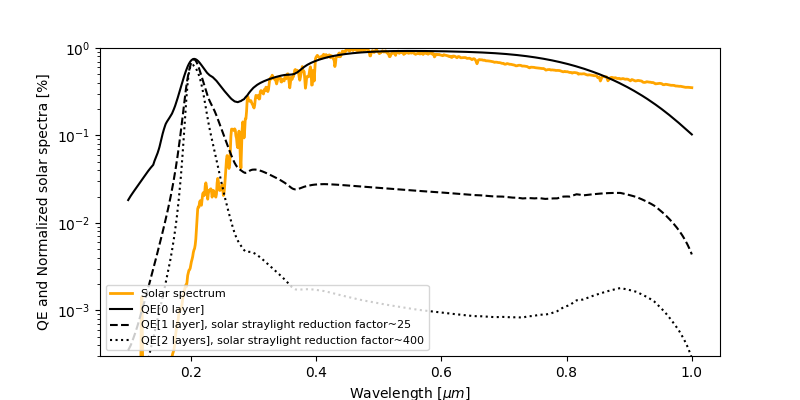

In [255]:
import sbpy
from sbpy import  calib
import astropy.units as u
from astropy.table import Table

import pandas as pd
# url = f"https://docs.google.com/spreadsheets/d/1uW2-hWWcv-l6AgtIaG9IHKCsKfP_ecP-/edit?usp=sharing&ouid=111063959106646075259&rtpof=true&sd=true"
# QE = Table.from_pandas(pd.read_csv(url))


# sheet_id = "1uW2-hWWcv-l6AgtIaG9IHKCsKfP_ecP-"
# sheet_name = "Models"
# url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
# QE = Table.from_pandas(pd.read_csv(url))

QE = Table.read("/Users/Vincent/Github/FIREBallIMO/FireBallIMO/PSFDetector/efficiencies/QE_2024.txt",format="ascii")[1:-1]

sun =  sbpy.calib.Sun.from_default()
wave = QE["wave"]  * u.nm 
# wave = np.arange(215, 1000,1) * u.nm
fluxd = sun.observe(wave)      
plt.figure(figsize=(8,4))        
plt.plot(wave/1000,fluxd/fluxd.max(),label="Solar spectrum",c="orange",lw=2)
plt.semilogy(QE["wave"]/1000,QE["FIREBall 3-layer ARC Model"]/100,"k-",label="QE[0 layer]")
plt.semilogy(QE["wave"]/1000,QE["eff. QE (1layer)"]/100,"k--",label="QE[1 layer], solar straylight reduction factor~25")
plt.semilogy(QE["wave"]/1000,QE["eff. QE (2 layers)"]/100,"k:",label="QE[2 layers], solar straylight reduction factor~400")

sum_21 = np.array([ np.sum((QE["wave"]*QE["eff. QE (2 layers)"])[wave>w])  / np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  for w in wave ] )
sum_10 = np.array([ np.sum((QE["wave"]*QE["eff. QE (1layer)"])[wave>w])  / np.sum((QE["wave"]*QE["FIREBall 3-layer ARC Model"])[wave>w])  for w in wave ] )
  
mask =wave > 220* u.nm
# plt.semilogy(wave[mask],sum_21[mask],label="Ratio integrated flux 2layers/1layer (med=%0.3f)"%(np.nanmedian(sum_21[mask])))
# plt.semilogy(wave[mask],sum_10[mask],label="Ratio integrated flux 1layer/0layer (med=%0.3f)"%(np.nanmedian(sum_10[mask])))
flux_det1 = np.sum((QE["wave"]*QE["eff. QE (1layer)"])[mask])
flux_det2 = np.sum((QE["wave"]*QE["eff. QE (2 layers)"])[mask])
plt.legend(fontsize=8)
# plt.grid()
plt.xlabel(r"Wavelength [$\mu m$]")
plt.ylabel("QE and Normalized solar spectra [%]")
plt.ylim((0.0003,1))
print(flux_det2/flux_det1)
print(flux_det1/flux_det2)
plt.show()